In [ ]:
import os
path = os.getcwd()

if path[1:5] == 'Home':
    %run /Home/siv30/wad005/useful_py_functions/matplotlib_custom_style_and_macros.py
    %run /Home/siv30/wad005/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Home/siv30/wad005/master/GRB/src/dau_det_distribution.ipynb
    %run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb

else:
    %run /Users/andreas/phys/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Users/andreas/phys/master/GRB/src/dau_det_distribution.ipynb
    %run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
    %run /Users/andreas/phys/master/GRB//xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
    %run /Users/andreas/phys/master/GRB//xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb
    
from stingray import Lightcurve as LC
from stingray import CrossCorrelation as CC
import numpy as np
import matplotlib.pyplot as plt
import os, re, sys

from gbm.data import TTE,RSP,Trigdat
from gbm.binning.unbinned import bin_by_time
from gbm.plot import Lightcurve, Spectrum
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial #working in ctime for example
%matplotlib inline

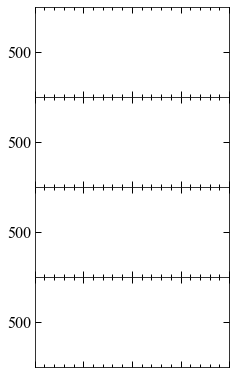

In [2]:
fig = plt.figure(figsize=(10, 5))

ax_height = 1/4

ax1 = fig.add_axes([0.1, 1-ax_height, 0.27, ax_height], xticklabels=[], ylim=(0, 1e3))
ax2 = fig.add_axes([0.1, 1-2*ax_height, 0.27, ax_height], xticklabels=[], ylim=(0, 1e3))
ax3 = fig.add_axes([0.1, 1-3*ax_height, 0.27, ax_height], xticklabels=[], ylim=(0, 1e3))
ax4 = fig.add_axes([0.1, 1-4*ax_height, 0.27, ax_height], xticklabels=[], ylim=(0, 1e3))


# set the yticks for each subplot
ax1.set_yticks([500])
ax2.set_yticks([500])
ax3.set_yticks([500])
ax4.set_yticks([500])

plt.show()

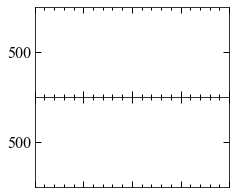

In [3]:
fig = plt.figure(figsize=(10, 5))

ax_height = 1/4

ax1 = fig.add_axes([0.1, 1-ax_height, 0.27, ax_height], xticklabels=[], ylim=(0, 1e3))
ax2 = fig.add_axes([0.1, 1-2*ax_height, 0.27, ax_height], xticklabels=[], ylim=(0, 1e3))



# set the yticks for each subplot
ax1.set_yticks([500])
ax2.set_yticks([500])


plt.show()

# GRB181222B

In [46]:
bins_181222B = np.arange(-0.512,1.058,0.002)

In [19]:
tlagg_asim = -0.44

df_asim = harvest_data(fn='2018_12_22_20_11_36',T0='2018-12-22T20:11:36.576')
df_asim['tus']+=tlagg_asim
tus_asim = df_asim['tus'].to_numpy()
tus_asim = tus_asim[np.searchsorted(tus_asim,-2):]
#bin tus_asim by the bins specified by KW

dau/det starting from index 1
tus array given in seconds
safety time:  0.507 % removed
sorted by tus (s)


In [5]:
#importing KW LC

kw_fn = 'GRB181222B_2ms.txt'
kw_df = pd.read_csv(kw_lc_path+kw_fn,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float32), kw_df["Tf"].to_numpy(dtype=np.float32),kw_df["G1"].to_numpy(dtype=np.float32), kw_df["G2"].to_numpy(dtype=np.float32), kw_df["G3"].to_numpy(dtype=np.float32)
kw_df.head()

,Ti,Tf,G1,G2,G3
0,-0.512,-0.510,0.00,1.00,0.0
1,-0.510,-0.508,5.04,1.00,0.0
2,-0.508,-0.506,1.00,0.00,0.0
3,-0.506,-0.504,0.00,0.00,1.0
4,-0.504,-0.502,1.00,2.01,0.0


## FERMI extraction

In [28]:
GRB_id = "GRB181222B"
bn='bn181222841' # GRB id for Fermi
data_dir = path_FERMI_dir + bn +"/" #setting path to data dir
unit='all' #which units to use. which filenames to open

fn_trigdat = data_dir+'glg_trigdat_'+unit+'_'+bn+'_v01.fit' #check of its a different v01.fit

trigdat = Trigdat.open(fn_trigdat)
print(trigdat)
print(trigdat.trigtime)


# Once extracted, it has the full capabilities of the [```Ctime```](./PhaiiData.ipynb) class.  You can also retrieve the sum of the detectors:
# the triggered detectors
trig_dets = trigdat.triggered_detectors
print(trig_dets)

grb_ra, grb_dec = 311.7605, 24.5163  #put in manually

all_dets=np.array(['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','na','nb','b0','b1'])
point_dets = np.zeros(shape=(all_dets.size,2))
for i in range(all_dets.size):
    point_dets[i,:] = trigdat.detector_pointing(all_dets[i], trigdat.trigtime)

#Q: Finding out where each detector is pointing and storing in a 14x2 matrix?
# ra, dec?

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Print dets with increasing angular separation from the GRB position
idx_sort_angsep = np.argsort(ang_sep) #sorting in increasing order
for i in idx_sort_angsep:
    print(all_dets[i],round(ang_sep[i],3))
    
#print(all_dets[idx_sort_angsep]) #sorting
#print(ang_sep[idx_sort_angsep]) #sorting


#The detectors nearest to the burst are listed first. If the degree is more than 60 deg, be careful to use the response function


glg_trigdat_all_bn181222841_v01.fit
567202302.438436
['n2', 'n3', 'n4', 'n6', 'n7']
n4 26.787
n3 28.14
n7 57.267
n8 58.272
n6 59.46
b0 70.459
n5 73.398
n0 75.631
n1 88.522
nb 106.295
n9 108.19
b1 109.541
n2 123.419
na 153.593


b0


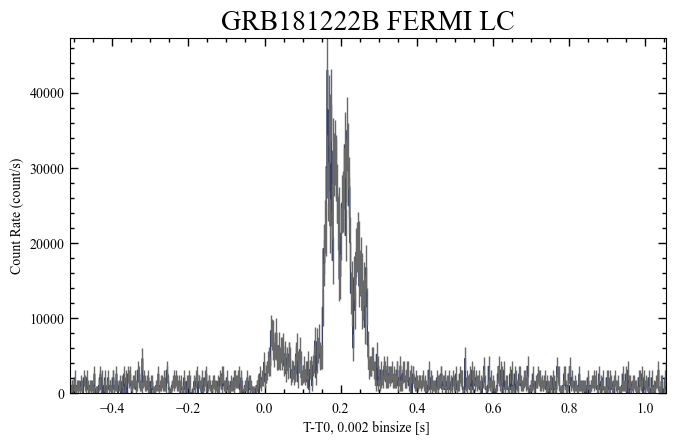

In [43]:
unit = all_dets[idx_sort_angsep][5] #for selecting the detector that are have the lowest incident angle to the GRB
#unit = trig_dets[1] #unit of the first trigger detector. What unit is this?
print(unit)

fn_tte_b0 = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'
fn_rsp_b0 = data_dir+'glg_cspec_'+unit+'_'+bn+'_v01.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels
# open a TTE file
tte_b0 = TTE.open(fn_tte_b0)

#bin_by_time is defined in imports. now have the spectra for each bin 
phaii = tte_b0.to_phaii(bin_by_time,binsize,time_ref=0.0) #puls height amplitude of second type ii. i: sum along columns, ii: for all channels

erange = (350,4e4)
lc_data = phaii.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data)
lcplot.xlim = (asim_edges[0],asim_edges[-1])
lcplot.ax.set_title(f'GRB181222B FERMI LC')
lcplot.ax.set_xlabel(f'T-T0, {binsize} binsize [s] ')
#plt.savefig(fname='/Users/andreas/phys/master/GRB/pyplots/GRB211211A_FERMI_LC.png')
plt.show()

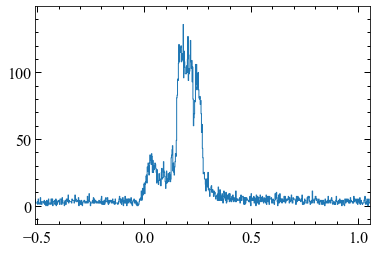

In [48]:
i_fermi_b0, j_fermi_b0 = np.searchsorted(tte_b0.data.time,-0.512),np.searchsorted(tte_b0.data.time,1.058)
fermi_tus = tte_b0.data.time[i_fermi_b0:j_fermi_b0] + 0.0008 #tlagg
hist_fermi_b0 = np.histogram(fermi_tus,bins_181222B)
fermi_counts_b0,fermi_edges_b0 = hist_fermi_b0[0],hist_fermi_b0[1]
plt.step(fermi_edges_b0[:-1],fermi_counts_b0)
plt.show()

n4


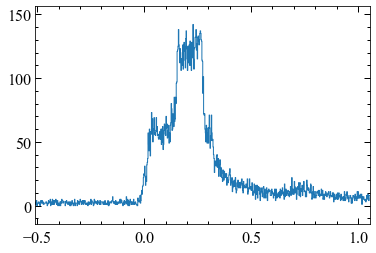

In [56]:
unit = all_dets[idx_sort_angsep][0] #for selecting the detector that are have the lowest incident angle to the GRB
#unit = trig_dets[1] #unit of the first trigger detector. What unit is this?
print(unit)

fn_tte_naI = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'
fn_rsp_naI = data_dir+'glg_cspec_'+unit+'_'+bn+'_v01.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels
# open a TTE file
tte_naI = TTE.open(fn_tte_naI)

i_fermi_naI, j_fermi_naI = np.searchsorted(tte_naI.data.time,-0.512),np.searchsorted(tte_naI.data.time,1.058)
fermi_tus_naI = tte_naI.data.time[i_fermi_naI:j_fermi_naI] + 0.0008 #tlagg
hist_fermi_naI = np.histogram(fermi_tus_naI,bins_181222B)
fermi_counts_naI,fermi_edges_naI = hist_fermi_naI[0],hist_fermi_naI[1]
plt.step(fermi_edges_naI[:-1],fermi_counts_naI)
plt.show()

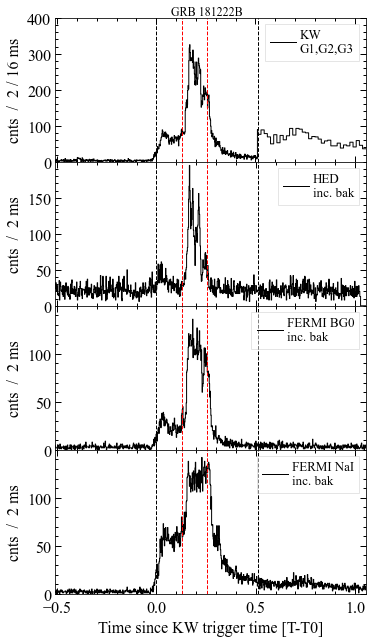

In [85]:
fig = plt.figure(figsize=(16, 8))

binsize=0.002
intervals = [[0.0,0.512],[0.128,0.256]]

ax_height = 1/4

ax1 = fig.add_axes([0.1, 1-ax_height, 0.27, ax_height], xticklabels=[], ylim=(0, 400))
ax2 = fig.add_axes([0.1, 1-2*ax_height, 0.27, ax_height], xticklabels=[], ylim=(0, 200))
ax3 = fig.add_axes([0.1, 1-3*ax_height, 0.27, ax_height], xticklabels=[], ylim=(0, 150))
ax4 = fig.add_axes([0.1, 1-4*ax_height, 0.27, ax_height], ylim=(0, 150))


# set the yticks for each subplot

ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([])

kw_dt = np.round(np.diff(kw_bin_lo),3)
jx_kw = np.where(kw_dt>binsize)[0][0]+35 #finding first entry where the binsize increases
kw_counts_1 = G1[:jx_kw]+G2[:jx_kw]+G3[:jx_kw]
#kw_counts_2 = G1[jx_kw:jx_kw+100]+G1[jx_kw:jx_kw+100]+G1[jx_kw:jx_kw+100]/8
ax1.step(x=kw_bin_lo[:jx_kw],y=kw_counts_1,where='pre',label='KW\nG1,G2,G3',color='black')
ax1.set_yticks([0,100,200,300,400])
ax1.set_ylabel(f'cnts  /  {round(binsize*1e3)} / 16 ms')
ax1.vlines(x=intervals[0][0],ymin=0,ymax=400,color='black',linestyle='--')
ax1.vlines(x=intervals[0][1],ymin=0,ymax=400,color='black',linestyle='--')
ax1.vlines(x=intervals[1][0],ymin=0,ymax=400,color='red',linestyle='--')
ax1.vlines(x=intervals[1][1],ymin=0,ymax=400,color='red',linestyle='--')
#----------------------------------------------------------------------------------
hist = np.histogram(tus_asim,np.arange(-0.512,1.058,0.002))
asim_counts, asim_edges = hist[0],hist[1]
ax2.step(asim_edges[:-1],asim_counts,label='HED\ninc. bak',color='black')
ax2.set_yticks([0,50,100,150])
ax2.set_ylabel(f'cnts  /  {round(binsize*1e3)} ms')
ax2.vlines(x=intervals[0][0],ymin=0,ymax=200,color='black',linestyle='--')
ax2.vlines(x=intervals[0][1],ymin=0,ymax=200,color='black',linestyle='--')
ax2.vlines(x=intervals[1][0],ymin=0,ymax=200,color='red',linestyle='--')
ax2.vlines(x=intervals[1][1],ymin=0,ymax=200,color='red',linestyle='--')
#---------------------------------------------------------------------------------
ax3.step(fermi_edges_b0[:-1],fermi_counts_b0,label='FERMI BG0\ninc. bak',color='black')
ax3.set_yticks([0,50,100])
ax3.set_ylabel(f'cnts  /  {round(binsize*1e3)} ms')
ax3.vlines(x=intervals[0][0],ymin=0,ymax=150,color='black',linestyle='--')
ax3.vlines(x=intervals[0][1],ymin=0,ymax=150,color='black',linestyle='--')
ax3.vlines(x=intervals[1][0],ymin=0,ymax=150,color='red',linestyle='--')
ax3.vlines(x=intervals[1][1],ymin=0,ymax=150,color='red',linestyle='--')
#-------------------------------------------------------------------------------
ax4.step(fermi_edges_naI[:-1],fermi_counts_naI,label='FERMI NaI\ninc. bak',color='black')
ax4.set_yticks([0,50,100])
ax4.set_ylabel(f'cnts  /  {round(binsize*1e3)} ms')
ax4.vlines(x=intervals[0][0],ymin=0,ymax=150,color='black',linestyle='--')
ax4.vlines(x=intervals[0][1],ymin=0,ymax=150,color='black',linestyle='--')
ax4.vlines(x=intervals[1][0],ymin=0,ymax=150,color='red',linestyle='--')
ax4.vlines(x=intervals[1][1],ymin=0,ymax=150,color='red',linestyle='--')
#-----------------------------------------------------------------------------

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.xlabel('Time since KW trigger time [T-T0]')
plt.suptitle('GRB 181222B',ha='center',va='top',x=0.232,y=1.02)
plt.savefig('/Home/siv30/wad005/master/GRB/pyplots/stacked_LC/GRB181222B.pdf', dpi=1000, format='pdf', bbox_inches='tight')


# GRB 190206A

In [17]:
bins_190206A = np.arange(-0.512,0.512,0.002)
binsize=0.002
tlagg_asim = -0.2955
#T0_asim = datetime.fromisoformat('2020-12-27T15:14:06.853667') + timedelta(seconds=-0.531)
#print(T0_asim)
asimData = pd.read_csv('/Users/andreas/phys/master/GRB/MATLAB/andrey_mezentsev/GRB190206A.csv')
asimData['tus']/=1e6
asimData['tus']+=tlagg_asim
asim_tus = asimData['tus'].to_numpy()
asimData.head()

,tus,dau,det,typ,erg
0,-1.002595,3,2,0,420
1,-1.002323,3,1,0,82
2,-1.002046,2,2,0,35
3,-1.001787,0,2,0,23
4,-1.001705,1,1,0,54


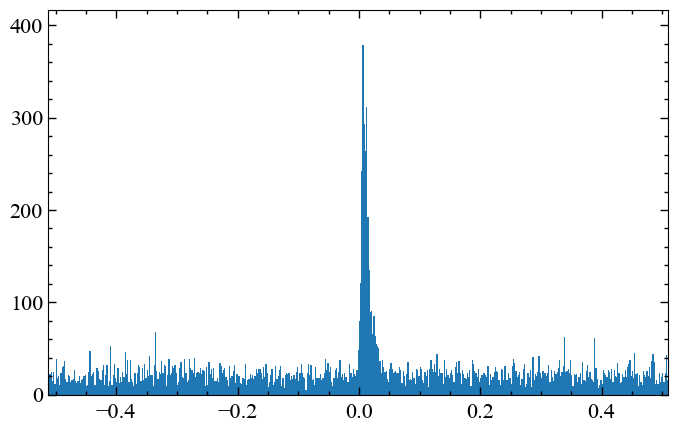

In [18]:
plt.hist(asim_tus,bins=bins_201227A)
plt.show()

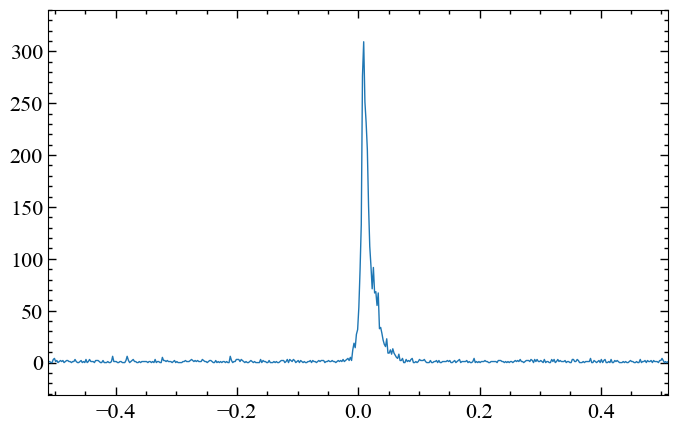

In [19]:
kw_filename = "GRB190206A_2ms.txt"
kw_file = kw_lc_path + kw_filename
binsize=0.002

kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)

kw_dt = np.round(np.diff(kw_bin_lo),3)
i_stop_kw = np.where(kw_dt>2*binsize)[0][0]

kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[:i_stop_kw], kw_bin_hi[:i_stop_kw], G1[:i_stop_kw],G2[:i_stop_kw], G3[:i_stop_kw]
kwCounts = G2+G3

bins = np.append(kw_bin_lo,kw_bin_hi[-1]) #standard bins

kw_lc = LC(time=np.round(kw_bin_lo + binsize/2,3), counts=kwCounts, skip_checks=True,dt=binsize)
kw_lc.plot()

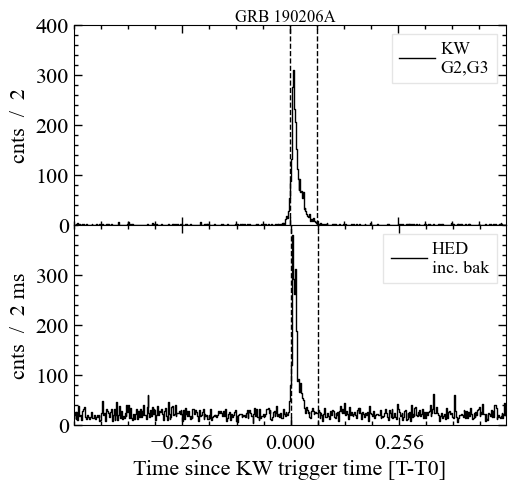

In [60]:
fig = plt.figure(figsize=(16, 8))

binsize=0.002
intervals = [0.0,0.064]

ax_height = 1/4

ax1 = fig.add_axes([0.1, 1-ax_height, 0.27, ax_height],xticklabels=[], ylim=(0, 400))
ax2 = fig.add_axes([0.1, 1-2*ax_height, 0.27, ax_height], ylim=(0, 400))


ax1.step(x=kw_lc.bin_lo,y=kw_lc.counts,where='pre',label='KW\nG2,G3',color='black')
ax1.set_yticks([0,100,200,300,400])
ax1.set_ylabel(f'cnts  /  {round(binsize*1e3)}')
ax1.vlines(x=intervals[0],ymin=0,ymax=400,color='black',linestyle='--')
ax1.vlines(x=intervals[1],ymin=0,ymax=400,color='black',linestyle='--')
#----------------------------------------------------------------------------------
hist = np.histogram(asim_tus,kw_lc.bin_lo)
asim_counts, asim_edges = hist[0],hist[1]
ax2.step(asim_edges[:-1],asim_counts,label='HED\ninc. bak',color='black')
ax2.set_yticks([0,100,200,300])
ax2.set_ylabel(f'cnts  /  {round(binsize*1e3)} ms')
ax2.vlines(x=intervals[0],ymin=0,ymax=400,color='black',linestyle='--')
ax2.vlines(x=intervals[1],ymin=0,ymax=400,color='black',linestyle='--')

ax1.legend()
ax2.legend()
ax2.set_xticks([-0.256,0,0.256])
ax1.set_xticks([-0.256,0,0.256])

plt.xlabel('Time since KW trigger time [T-T0]')
plt.suptitle('GRB 190206A',ha='center',va='top',x=0.232,y=1.02)
plt.savefig('/Users/andreas/phys/master/GRB/pyplots/stacked_LC/GRB190206A.pdf', dpi=1000, format='pdf', bbox_inches='tight')
plt.show()


# GRB 190305A

In [77]:
binsize=0.016
bins_190305A = np.arange(-0.512,2,binsize)
tlagg_asim = 0.5150625
#T0_asim = datetime.fromisoformat('2020-12-27T15:14:06.853667') + timedelta(seconds=-0.531)
#print(T0_asim)
asimData = pd.read_csv('/Users/andreas/phys/master/GRB/MATLAB/andrey_mezentsev/GRB190305A.csv')
asimData['tus']/=1e6
asimData['tus']+=tlagg_asim
tus_asim = asimData['tus'].to_numpy()
asimData.head()

,tus,dau,det,typ,erg
0,-0.205330,0,0,0,1768
1,-0.205166,0,2,0,1838
2,-0.205166,0,1,0,655
3,-0.205105,2,0,0,95
4,-0.205105,3,1,0,77


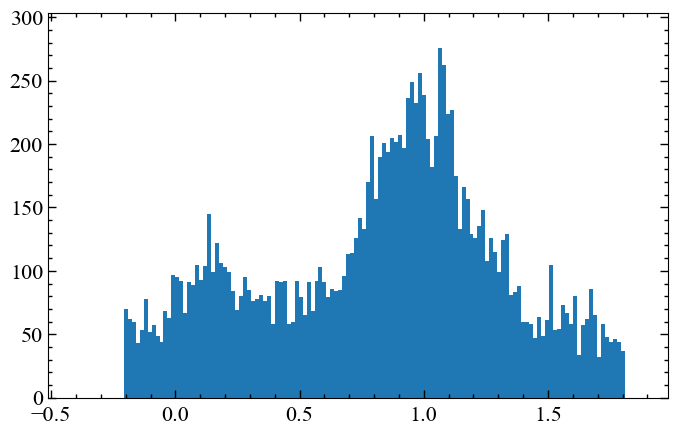

2019-03-05 13:05:20.615007


In [78]:
plt.hist(tus_asim,bins_190305A)
plt.show()
T0 = datetime.fromisoformat('2019-03-05T13:05:20.099945') + timedelta(seconds=tlagg_asim)
print(T0)

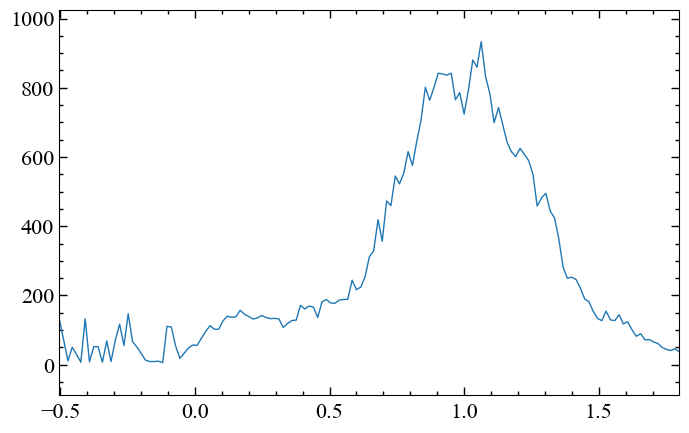

In [89]:
kw_filename = "GRB190305A_16ms.txt"
kw_file = kw_lc_path + kw_filename

kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)


i_stop_kw = np.searchsorted(kw_bin_lo,1.792)

kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[:i_stop_kw], kw_bin_hi[:i_stop_kw], G1[:i_stop_kw],G2[:i_stop_kw], G3[:i_stop_kw]
kwCounts = G2+G3

bins = np.append(kw_bin_lo,kw_bin_hi[-1]) #standard bins

kw_lc = LC(time=np.round(kw_bin_lo + binsize/2,3), counts=kwCounts, skip_checks=True,dt=binsize)
kw_lc.plot()


bins_190305A = np.append(np.round(kw_lc.bin_lo,3),kw_lc.bin_hi[-1])

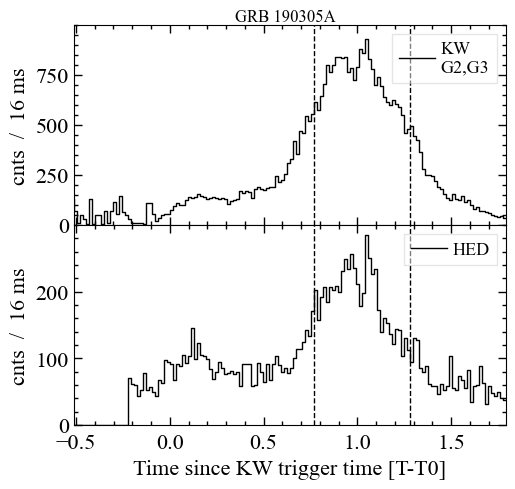

In [95]:
fig = plt.figure(figsize=(16, 8))

binsize=0.002
intervals = [0.768,1.280]

ax_height = 1/4

ax1 = fig.add_axes([0.1, 1-ax_height, 0.27, ax_height], xticklabels=[], ylim=(0, 1000))
ax2 = fig.add_axes([0.1, 1-2*ax_height, 0.27, ax_height], ylim=(0, 300))

ax2.set_yticks([])

ax1.step(x=kw_lc.bin_lo,y=kw_lc.counts,where='pre',label='KW\nG2,G3',color='black')
ax1.set_yticks([0,250,500,750])
ax1.set_ylabel(f'cnts  /  16 ms')
ax1.vlines(x=intervals[0],ymin=0,ymax=1000,color='black',linestyle='--')
ax1.vlines(x=intervals[1],ymin=0,ymax=1000,color='black',linestyle='--')
#----------------------------------------------------------------------------------
hist = np.histogram(asim_tus,bins=bins_190305A)
asim_counts, asim_edges = hist[0],hist[1]
ax2.step(asim_edges[:-1],asim_counts,label='HED',color='black')
ax2.set_yticks([0,100,200])
ax2.set_ylabel(f'cnts  /  16 ms')
ax2.vlines(x=intervals[0],ymin=0,ymax=300,color='black',linestyle='--')
ax2.vlines(x=intervals[1],ymin=0,ymax=300,color='black',linestyle='--')

ax1.legend()
ax2.legend()

plt.xlabel('Time since KW trigger time [T-T0]')
plt.suptitle('GRB 190305A',ha='center',va='top',x=0.232,y=1.02)
plt.savefig('/Users/andreas/phys/master/GRB/pyplots/stacked_LC/GRB190305A.pdf', dpi=1000, format='pdf', bbox_inches='tight')
plt.show()

# GRB 190606A

In [142]:
binsize=0.016
tlagg_asim = -0.5366225269343781
asimData = pd.read_csv('/Users/andreas/phys/master/GRB/MATLAB/andrey_mezentsev/GRB190606A.csv')
asimData['tus']/=1e6
asimData['tus']+=tlagg_asim
tus_asim = asimData['tus'].to_numpy()
asimData.head()

,tus,dau,det,typ,erg
0,-1.047156,0,0,0,57
1,-1.046935,2,2,0,80
2,-1.046935,0,1,0,1108
3,-1.046296,3,1,0,57
4,-1.046173,3,0,0,1327


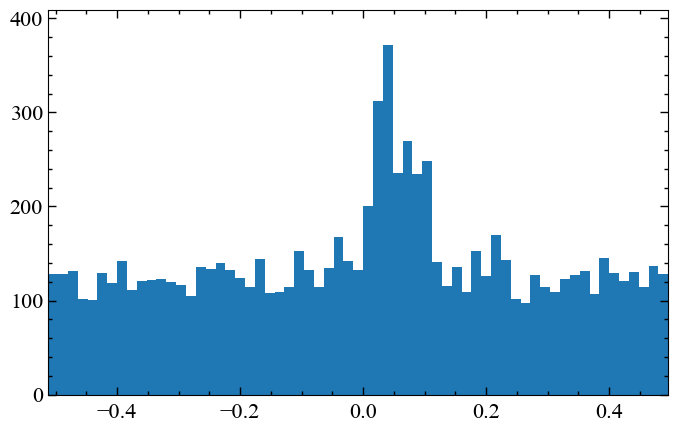

2019-06-06 01:55:06.781982


In [143]:
plt.hist(tus_asim,np.arange(-0.512,0.512,binsize))
plt.show()
T0 = datetime.fromisoformat('2019-06-06T01:55:07.318605') + timedelta(seconds=tlagg_asim)
print(T0)

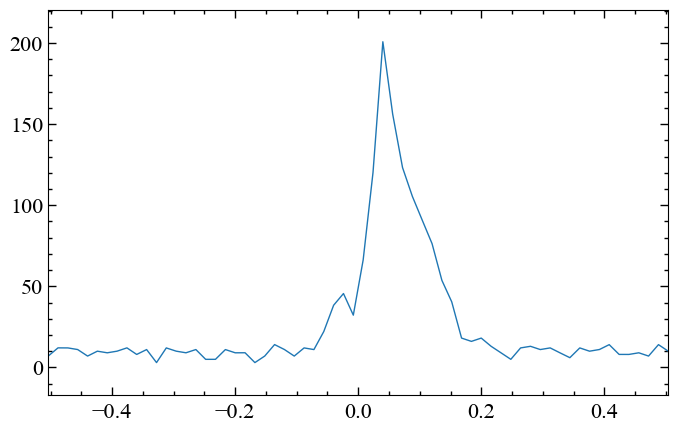

In [144]:
kw_filename = "GRB190606A_16ms.txt"
kw_file = kw_lc_path + kw_filename

kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)


i_stop_kw = np.searchsorted(kw_bin_lo,0.512)

kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[:i_stop_kw], kw_bin_hi[:i_stop_kw], G1[:i_stop_kw],G2[:i_stop_kw], G3[:i_stop_kw]
kwCounts = G2+G3

bins = np.append(kw_bin_lo,kw_bin_hi[-1]) #standard bins

kw_lc = LC(time=np.round(kw_bin_lo + binsize/2,3), counts=kwCounts, skip_checks=True,dt=binsize)
kw_lc.plot()


bins_190606A = np.append(np.round(kw_lc.bin_lo,3),kw_lc.bin_hi[-1])

In [150]:
GRB_id = "GRB190606A"
bn='bn190606080' # GRB id for Fermi
data_dir = path_FERMI_dir + bn +"/" #setting path to data dir
unit='all' #which units to use. which filenames to open

fn_trigdat = data_dir+'glg_trigdat_'+unit+'_'+bn+'_v02.fit' #check of its a different v01.fit

trigdat = Trigdat.open(fn_trigdat)
print(trigdat)
print(trigdat.trigtime)


# Once extracted, it has the full capabilities of the [```Ctime```](./PhaiiData.ipynb) class.  You can also retrieve the sum of the detectors:
# the triggered detectors
trig_dets = trigdat.triggered_detectors
print(trig_dets)

grb_ra, grb_dec = 311.7605, 24.5163  #put in manually

all_dets=np.array(['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','na','nb','b0','b1'])
point_dets = np.zeros(shape=(all_dets.size,2))
for i in range(all_dets.size):
    point_dets[i,:] = trigdat.detector_pointing(all_dets[i], trigdat.trigtime)

#Q: Finding out where each detector is pointing and storing in a 14x2 matrix?
# ra, dec?

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Print dets with increasing angular separation from the GRB position
idx_sort_angsep = np.argsort(ang_sep) #sorting in increasing order
for i in idx_sort_angsep:
    print(all_dets[i],round(ang_sep[i],3))

glg_trigdat_all_bn190606080_v02.fit
581478912.776248
['n0', 'n1', 'n3', 'n5']
na 53.347
b1 69.1
nb 70.753
n2 77.356
n9 98.392
n8 101.458
n5 109.357
b0 110.9
n1 120.513
n4 125.937
n7 127.899
n0 136.259
n6 141.585
n3 169.722


b1


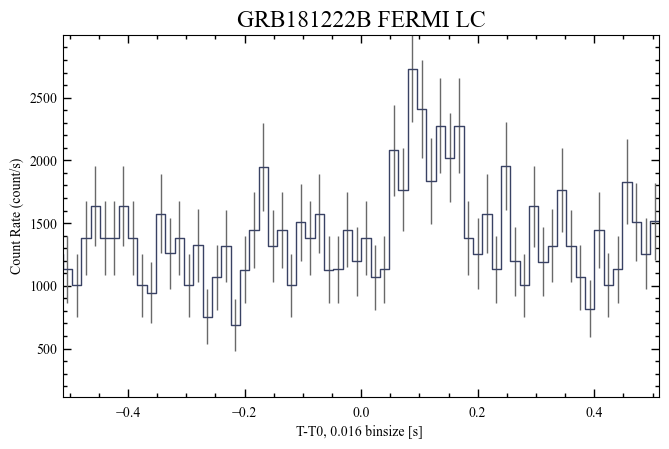

In [151]:
unit = all_dets[idx_sort_angsep][1] #for selecting the detector that are have the lowest incident angle to the GRB
#unit = trig_dets[1] #unit of the first trigger detector. What unit is this?
print(unit)

fn_tte_b0 = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'
fn_rsp_b0 = data_dir+'glg_cspec_'+unit+'_'+bn+'_v01.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels
# open a TTE file
tte_b0 = TTE.open(fn_tte_b0)

#bin_by_time is defined in imports. now have the spectra for each bin 
phaii = tte_b0.to_phaii(bin_by_time,binsize,time_ref=0.0) #puls height amplitude of second type ii. i: sum along columns, ii: for all channels

erange = (350,4e4)
lc_data = phaii.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data)
lcplot.xlim = (asim_edges[0],asim_edges[-1])
lcplot.ax.set_title(f'GRB181222B FERMI LC')
lcplot.ax.set_xlabel(f'T-T0, {binsize} binsize [s] ')
#plt.savefig(fname='/Users/andreas/phys/master/GRB/pyplots/GRB211211A_FERMI_LC.png')
plt.show()

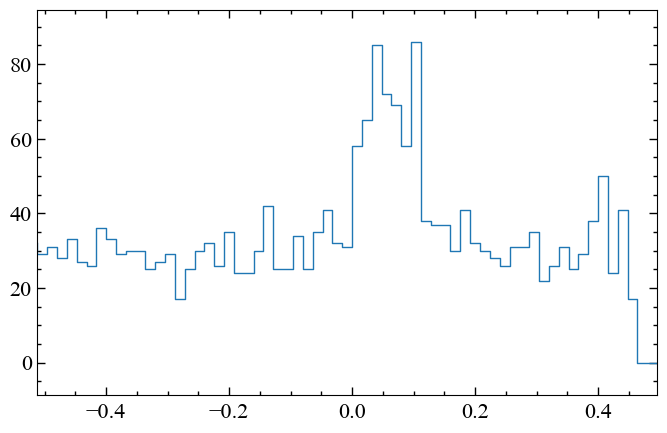

In [152]:
i_fermi_b0, j_fermi_b0 = np.searchsorted(tte_b0.data.time,-0.512),np.searchsorted(tte_b0.data.time,0.512)
fermi_tus = tte_b0.data.time[i_fermi_b0:j_fermi_b0]-0.042
hist_fermi_b0 = np.histogram(fermi_tus,bins_190606A)
fermi_counts_b0,fermi_edges_b0 = hist_fermi_b0[0],hist_fermi_b0[1]
plt.step(fermi_edges_b0[:-1],fermi_counts_b0)
plt.show()

na


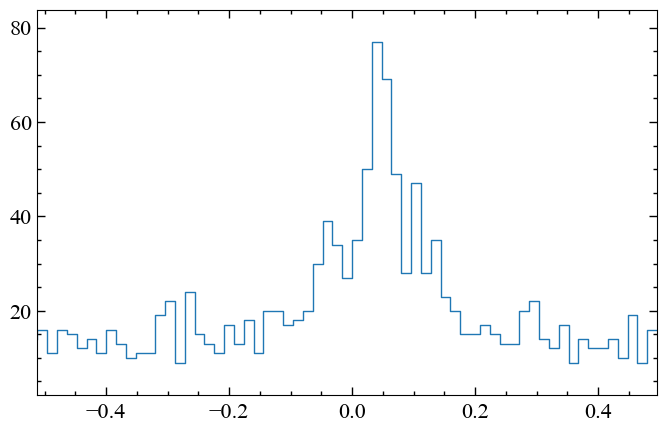

In [154]:
unit = all_dets[idx_sort_angsep][0] #for selecting the detector that are have the lowest incident angle to the GRB
#unit = trig_dets[1] #unit of the first trigger detector. What unit is this?
print(unit)

fn_tte_naI = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'
fn_rsp_naI = data_dir+'glg_cspec_'+unit+'_'+bn+'_v01.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels
# open a TTE file
tte_naI = TTE.open(fn_tte_naI)

i_fermi_naI, j_fermi_naI = np.searchsorted(tte_naI.data.time,-0.512),np.searchsorted(tte_naI.data.time,1.058)
fermi_tus_naI = tte_naI.data.time[i_fermi_naI:j_fermi_naI]-0.042
hist_fermi_naI = np.histogram(fermi_tus_naI,bins_190606A)
fermi_counts_naI,fermi_edges_naI = hist_fermi_naI[0],hist_fermi_naI[1]
plt.step(fermi_edges_naI[:-1],fermi_counts_naI)
plt.show()

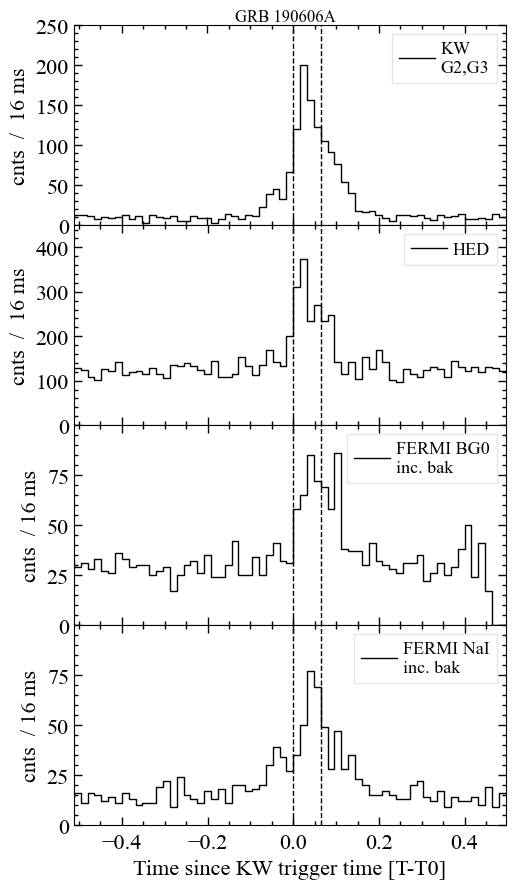

In [156]:
fig = plt.figure(figsize=(16, 8))

intervals = [0.00,0.064]

ax_height = 1/4

ax1 = fig.add_axes([0.1, 1-ax_height, 0.27, ax_height], xticklabels=[], ylim=(0, 250))
ax2 = fig.add_axes([0.1, 1-2*ax_height, 0.27, ax_height],xticklabels=[], ylim=(0, 450))
ax3 = fig.add_axes([0.1, 1-3*ax_height, 0.27, ax_height], xticklabels=[], ylim=(0, 100))
ax4 = fig.add_axes([0.1, 1-4*ax_height, 0.27, ax_height], ylim=(0, 100))


ax1.step(x=kw_lc.bin_lo,y=kw_lc.counts,where='pre',label='KW\nG2,G3',color='black')
ax1.set_yticks([0,50,100,150,200,250])
ax1.set_ylabel(f'cnts  /  16 ms')
ax1.vlines(x=intervals[0],ymin=0,ymax=250,color='black',linestyle='--')
ax1.vlines(x=intervals[1],ymin=0,ymax=250,color='black',linestyle='--')
#----------------------------------------------------------------------------------
hist = np.histogram(tus_asim,bins=bins_190606A)
asim_counts, asim_edges = hist[0],hist[1]
ax2.step(asim_edges[:-1],asim_counts,label='HED',color='black')
ax2.set_yticks([0,100,200,300,400])
ax2.set_ylabel(f'cnts  /  16 ms')
ax2.vlines(x=intervals[0],ymin=0,ymax=450,color='black',linestyle='--')
ax2.vlines(x=intervals[1],ymin=0,ymax=450,color='black',linestyle='--')
#---------------------------------------------------------------------------------
ax3.step(fermi_edges_b0[:-1],fermi_counts_b0,label='FERMI BG0\ninc. bak',color='black')
ax3.set_yticks([0,25,50,75])
ax3.set_ylabel(f'cnts  / 16 ms')
ax3.vlines(x=intervals[0],ymin=0,ymax=100,color='black',linestyle='--')
ax3.vlines(x=intervals[1],ymin=0,ymax=100,color='black',linestyle='--')
#-------------------------------------------------------------------------------
ax4.step(fermi_edges_naI[:-1],fermi_counts_naI,label='FERMI NaI\ninc. bak',color='black')
ax4.set_yticks([0,25,50,75])
ax4.set_ylabel(f'cnts  / 16 ms')
ax4.vlines(x=intervals[0],ymin=0,ymax=100,color='black',linestyle='--')
ax4.vlines(x=intervals[1],ymin=0,ymax=100,color='black',linestyle='--')
#-----------------------------------------------------------------------------

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.xlabel('Time since KW trigger time [T-T0]')
plt.suptitle('GRB 190606A',ha='center',va='top',x=0.232,y=1.02)
plt.savefig('/Users/andreas/phys/master/GRB/pyplots/stacked_LC/GRB190606A.pdf', dpi=1000, format='pdf', bbox_inches='tight')
plt.show()

# GRB 200521A

In [130]:
binsize=0.016
tlagg_asim = -0.814
asimData = pd.read_csv('/Users/andreas/phys/master/GRB/MATLAB/andrey_mezentsev/GRB200521A.csv')
asimData['tus']/=1e6
asimData['tus']+=tlagg_asim
tus_asim = asimData['tus'].to_numpy()
asimData.head()

,tus,dau,det,typ,erg
0,-0.961473,1,2,0,368
1,-0.960743,1,2,0,75
2,-0.960506,1,1,0,917
3,-0.960242,3,0,0,89
4,-0.959868,3,2,0,812


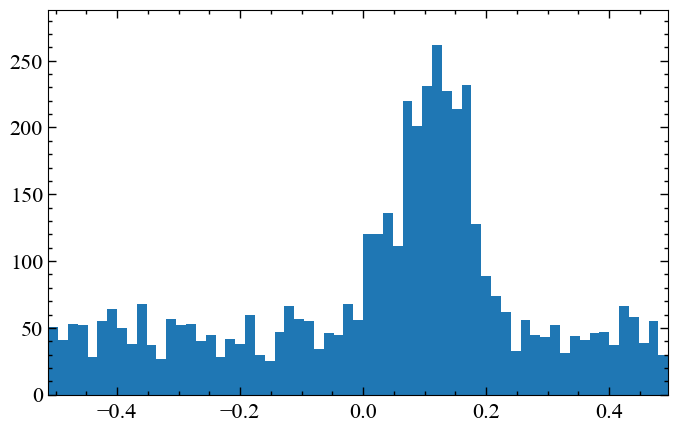

2020-05-21 12:16:39.004000


In [131]:
plt.hist(tus_asim,np.arange(-0.512,0.512,binsize))
plt.show()
T0 = datetime.fromisoformat('2020-05-21T12:16:39.818') + timedelta(seconds=tlagg_asim)
print(T0)

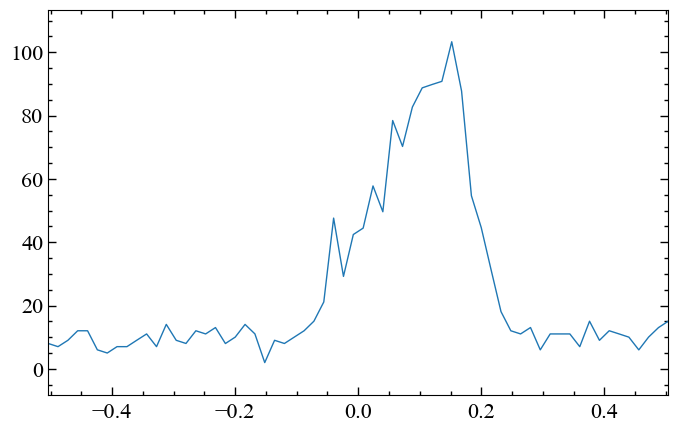

In [132]:
kw_filename = "GRB200521A_16ms.txt"
kw_file = kw_lc_path + kw_filename

kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)


i_stop_kw = np.searchsorted(kw_bin_lo,0.512)

kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[:i_stop_kw], kw_bin_hi[:i_stop_kw], G1[:i_stop_kw],G2[:i_stop_kw], G3[:i_stop_kw]
kwCounts = G2+G3

bins = np.append(kw_bin_lo,kw_bin_hi[-1]) #standard bins

kw_lc = LC(time=np.round(kw_bin_lo + binsize/2,3), counts=kwCounts, skip_checks=True,dt=binsize)
kw_lc.plot()


bins_200521A = np.append(np.round(kw_lc.bin_lo,3),kw_lc.bin_hi[-1])

# GRB 200716C

# GRB 201227A

In [2]:
bins_201227A = np.arange(-0.512,0.512,0.002)
binsize=0.002
tlagg_asim = -0.531
T0_asim = datetime.fromisoformat('2020-12-27T15:14:06.853667') + timedelta(seconds=-0.531)
print(T0_asim)

2020-12-27 15:14:06.322667


In [21]:
asimData = pd.read_csv('/Users/andreas/phys/master/GRB/MATLAB/andrey_mezentsev/GRB201227A.csv')
asimData['tus']/=1e6
asimData['tus']+=tlagg_asim
asimData.head()

,tus,dau,det,typ,erg
0,-1.000611,0,1,0,27
1,-1.000611,2,1,0,44
2,-1.000221,0,2,0,1805
3,-1.000221,1,0,0,1595
4,-0.999945,2,1,0,167


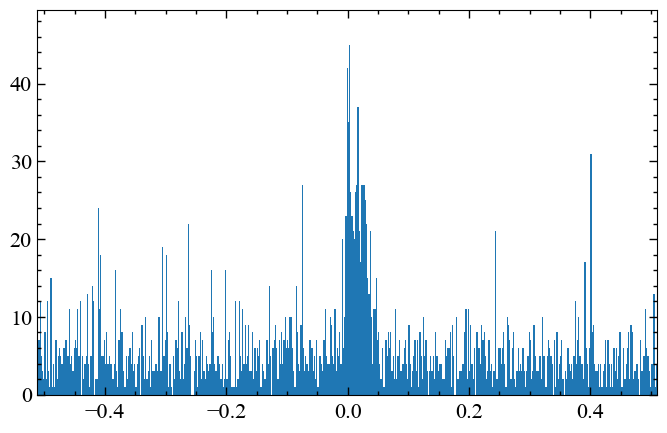

In [23]:
plt.hist(asimData['tus'].to_numpy(),bins=bins_201227A)
plt.show()

In [32]:
#importing KW LC
kw_fn = 'GRB201227A_2ms.txt'
kw_df = pd.read_csv(kw_lc_path+kw_fn,sep='\s+')
kw_bin_hi =kw_df["Tf"].to_numpy(dtype=np.float32)
jx_kw = np.searchsorted(kw_bin_hi,0.512)
kw_df= kw_df.truncate(after=jx_kw)
G1,G2,G3 = kw_df["G1"].to_numpy(dtype=np.float32), kw_df["G2"].to_numpy(dtype=np.float32), kw_df["G3"].to_numpy(dtype=np.float32)
kw_bin_lo,kw_bin_hi =kw_df["Ti"].to_numpy(dtype=np.float32), kw_df["Tf"].to_numpy(dtype=np.float32)
kw_df.head()

,Ti,Tf,G1,G2,G3
0,-0.512,-0.510,2.01,0.0,1.00
1,-0.510,-0.508,2.01,0.0,2.01
2,-0.508,-0.506,4.03,1.0,0.00
3,-0.506,-0.504,0.00,1.0,0.00
4,-0.504,-0.502,1.00,0.0,0.00


In [68]:
GRB_id = "GRB201227A"
bn='bn201227635' # GRB id for Fermi
data_dir = path_FERMI_dir + bn +"/" #setting path to data dir
unit='all' #which units to use. which filenames to open

fn_trigdat = data_dir+'glg_trigdat_'+unit+'_'+bn+'_v01.fit' #check of its a different v01.fit

trigdat = Trigdat.open(fn_trigdat)
print(trigdat)
print(trigdat.trigtime)


# Once extracted, it has the full capabilities of the [```Ctime```](./PhaiiData.ipynb) class.  You can also retrieve the sum of the detectors:
# the triggered detectors
trig_dets = trigdat.triggered_detectors
print(trig_dets)

grb_ra, grb_dec = 170.121,-73.613  #put in manually

all_dets=np.array(['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','na','nb','b0','b1'])
point_dets = np.zeros(shape=(all_dets.size,2))
for i in range(all_dets.size):
    point_dets[i,:] = trigdat.detector_pointing(all_dets[i], trigdat.trigtime)

#Q: Finding out where each detector is pointing and storing in a 14x2 matrix?
# ra, dec?

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Print dets with increasing angular separation from the GRB position
idx_sort_angsep = np.argsort(ang_sep) #sorting in increasing order
for i in idx_sort_angsep:
    print(all_dets[i],round(ang_sep[i],3))

glg_trigdat_all_bn201227635_v01.fit
630774852.414564
['n4', 'n8']
n4 45.002
n8 67.702
b0 72.906
n5 75.347
n3 91.187
nb 104.305
b1 107.094
n7 107.96
n2 113.344
n6 124.796
n1 132.295
na 134.225
n0 138.508
n9 165.202


b0


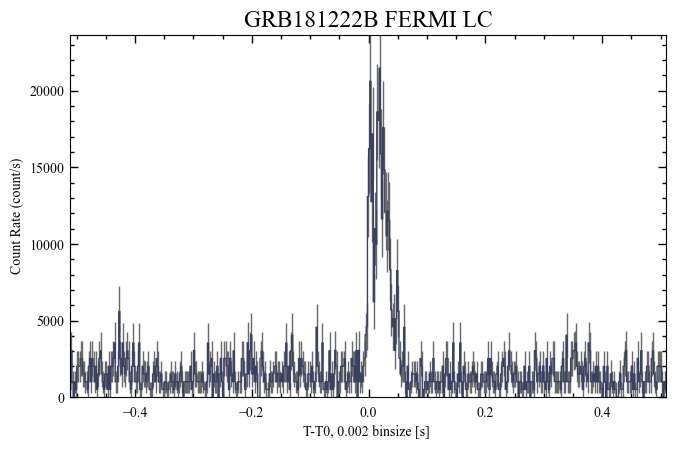

In [72]:
unit = all_dets[idx_sort_angsep][2] #for selecting the detector that are have the lowest incident angle to the GRB
#unit = trig_dets[1] #unit of the first trigger detector. What unit is this?
print(unit)

fn_tte_b0 = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'
fn_rsp_b0 = data_dir+'glg_cspec_'+unit+'_'+bn+'_v01.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels
# open a TTE file
tte_b0 = TTE.open(fn_tte_b0)

i_fermi_b0, j_fermi_b0 = np.searchsorted(tte_b0.data.time,-0.512),np.searchsorted(tte_b0.data.time,1.058)
fermi_tus_b0 = tte_b0.data.time[i_fermi_b0:j_fermi_b0] - 0.004 #tlagg
hist_fermi_b0 = np.histogram(fermi_tus_b0,bins_201227A)
fermi_counts_b0,fermi_edges_b0 = hist_fermi_b0[0],hist_fermi_b0[1]

#bin_by_time is defined in imports. now have the spectra for each bin 
phaii = tte_b0.to_phaii(bin_by_time,binsize,time_ref=0.0) #puls height amplitude of second type ii. i: sum along columns, ii: for all channels

erange = (350,4e4)
lc_data = phaii.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data)
lcplot.xlim = (asim_edges[0],asim_edges[-1])
lcplot.ax.set_title(f'GRB181222B FERMI LC')
lcplot.ax.set_xlabel(f'T-T0, {binsize} binsize [s] ')
plt.show()

n4


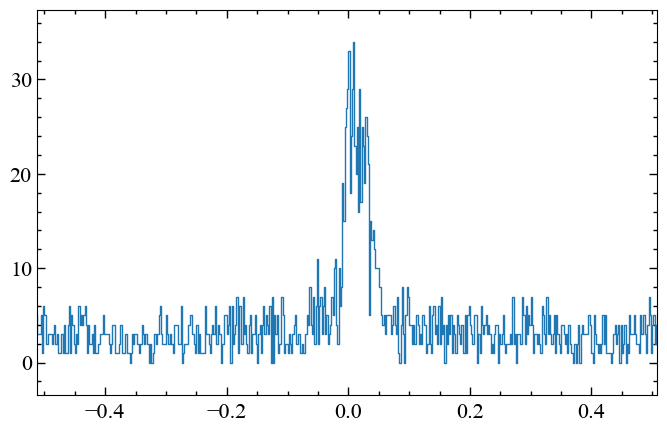

In [73]:
unit = all_dets[idx_sort_angsep][0] #for selecting the detector that are have the lowest incident angle to the GRB
#unit = trig_dets[1] #unit of the first trigger detector. What unit is this?
print(unit)

fn_tte_naI = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'
fn_rsp_naI = data_dir+'glg_cspec_'+unit+'_'+bn+'_v01.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels
# open a TTE file
tte_naI = TTE.open(fn_tte_naI)

i_fermi_naI, j_fermi_naI = np.searchsorted(tte_naI.data.time,-0.512),np.searchsorted(tte_naI.data.time,1.058)
fermi_tus_naI = tte_naI.data.time[i_fermi_naI:j_fermi_naI] - 0.004 #tlagg
hist_fermi_naI = np.histogram(fermi_tus_naI,bins_201227A)
fermi_counts_naI,fermi_edges_naI = hist_fermi_naI[0],hist_fermi_naI[1]
plt.step(fermi_edges_naI[:-1],fermi_counts_naI)
plt.show()

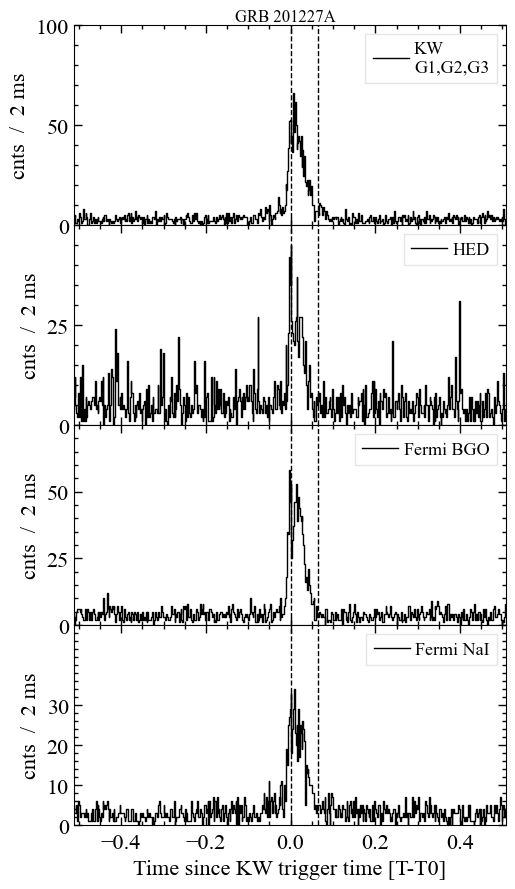

In [83]:
fig = plt.figure(figsize=(16, 8))

binsize=0.002
intervals = [[0.0,0.064]]

ax_height = 1/4

ax1 = fig.add_axes([0.1, 1-ax_height, 0.27, ax_height], xticklabels=[], ylim=(0, 100))
ax2 = fig.add_axes([0.1, 1-2*ax_height, 0.27, ax_height], xticklabels=[], ylim=(0, 50))
ax3 = fig.add_axes([0.1, 1-3*ax_height, 0.27, ax_height], xticklabels=[], ylim=(0, 75))
ax4 = fig.add_axes([0.1, 1-4*ax_height, 0.27, ax_height], ylim=(0, 50))


# set the yticks for each subplot

ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([])

kw_counts = G1+G2+G3
ax1.step(x=kw_bin_lo[:-1],y=kw_counts[:-1],where='pre',label='KW\nG1,G2,G3',color='black')
ax1.set_yticks([0,50,100])
ax1.set_ylabel(f'cnts  /  {round(binsize*1e3)} ms')
ax1.vlines(x=intervals[0][0],ymin=0,ymax=100,color='black',linestyle='--')
ax1.vlines(x=intervals[0][1],ymin=0,ymax=100,color='black',linestyle='--')
#----------------------------------------------------------------------------------
hist = np.histogram(asimData['tus'].to_numpy(),bins_201227A)
asim_counts, asim_edges = hist[0],hist[1]
ax2.step(np.round(asim_edges[:-1],3),asim_counts,label='HED',color='black')
ax2.set_yticks([0,25])
ax2.set_ylabel(f'cnts  /  {round(binsize*1e3)} ms')
ax2.vlines(x=intervals[0][0],ymin=0,ymax=50,color='black',linestyle='--')
ax2.vlines(x=intervals[0][1],ymin=0,ymax=50,color='black',linestyle='--')

#---------------------------------------------------------------------------------
ax3.step(fermi_edges_b0[:-1],fermi_counts_b0,label='Fermi BGO',color='black')
ax3.set_yticks([0,25,50])
ax3.set_ylabel(f'cnts  /  {round(binsize*1e3)} ms')
ax3.vlines(x=intervals[0][0],ymin=0,ymax=75,color='black',linestyle='--')
ax3.vlines(x=intervals[0][1],ymin=0,ymax=75,color='black',linestyle='--')
#-------------------------------------------------------------------------------
ax4.step(fermi_edges_naI[:-1],fermi_counts_naI,label='Fermi NaI',color='black')
ax4.set_yticks([0,10,20,30])
ax4.set_ylabel(f'cnts  /  {round(binsize*1e3)} ms')
ax4.vlines(x=intervals[0][0],ymin=0,ymax=50,color='black',linestyle='--')
ax4.vlines(x=intervals[0][1],ymin=0,ymax=50,color='black',linestyle='--')
#-----------------------------------------------------------------------------

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.xlabel('Time since KW trigger time [T-T0]')
plt.suptitle('GRB 201227A',ha='center',va='top',x=0.232,y=1.02)
#plt.savefig('/Users/andreas/phys/master/GRB/pyplots/stacked_LC/GRB201227A.pdf', dpi=1000, format='pdf', bbox_inches='tight')
plt.show()

# GRB 210424B

# GRB 210619B

# GRB 211211A